In [1]:
import pandas as pd
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import Image, display

def open_ost(ost_path:Path):
    if not ost_path.exists():
        return -1, -1, -1, -1, -1, -1 ,-1
    with open(ost_path) as json_data:
        score_json = json.load(json_data)
    lddt = score_json["lddt"] if "lddt" in score_json else 0
    bb_lddt = score_json["bb_lddt"] if "bb_lddt" in score_json else 0
    tm_score = score_json["tm_score"] if "tm_score" in score_json else 0
    inconsistent_residues = score_json["inconsistent_residues"] if "inconsistent_residues" in score_json else -1
    length = len(score_json["local_lddt"]) if "local_lddt" in score_json else -1
    model_bad_bonds = len(score_json["reference_bad_bonds"]) if "reference_bad_bonds" in score_json else -1
    model_bad_angles = len(score_json["reference_bad_angles"]) if "reference_bad_angles" in score_json else -1
    alignment = score_json["aln"][0]
    alignment_reference = alignment.split("\n")[1]
    alignment_model = alignment.split("\n")[3]
    return lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, alignment_model, alignment_reference

def open_secstruc(secstruc_path:Path):
    if not secstruc_path.exists():
        return None, None, -1, -1, -1, -1
    with open(secstruc_path) as json_data:
        json_dict = json.load(json_data)
    secstruc_string = "".join(json_dict["secstruc"])
    sequence_string = "".join(json_dict["residues"])
    gap_total = json_dict["-_total"]
    gap_relative = json_dict["-_rel"]
    return secstruc_string, sequence_string, len(secstruc_string), len(sequence_string), gap_total, gap_relative

In [2]:
scores = []
for protein_path in Path("protein_output_25032025").glob("*"):
    print(protein_path)
    protein=protein_path.name
    max_index = None
    for score_file in sorted(list(protein_path.glob("it_*.json"))):
        index = int(str(score_file).split("_index_")[1][:-len(".json")])
        it = int(str(score_file.name)[3])
        if max_index is None: # only in closest frame --> prediction
            max_index = index
        if abs(max_index-index)<5:
            continue
        lddt, bb_lddt, tm_score, inconsistent_residues, length, model_bad_bonds, model_bad_angles, alignment_model, alignment_reference = open_ost(score_file)
        curr_entry = {"protein":protein, "it":it, "index":index,"max_index":max_index, "lddt": lddt,"lddt_bb":bb_lddt,  "tm": tm_score, "alignment_model":alignment_model,"alignment_reference": alignment_reference, "inconsistent_residues": inconsistent_residues, "length": length,  "bad_bonds":  model_bad_bonds,  "bad_angles":  model_bad_angles}
        scores.append(curr_entry)

protein_output_25032025/2jmrA
protein_output_25032025/5keqF
protein_output_25032025/4g0dZ
protein_output_25032025/2p3vA
protein_output_25032025/3j9cA
protein_output_25032025/2naoF
protein_output_25032025/2mwfA
protein_output_25032025/2k0qA
protein_output_25032025/2lv1A
protein_output_25032025/4rmbA
protein_output_25032025/2lejA
protein_output_25032025/1mnmB
protein_output_25032025/2lelA
protein_output_25032025/4j3oF
protein_output_25032025/5fluE
protein_output_25032025/3o44A
protein_output_25032025/2n0aD
protein_output_25032025/2kb8A
protein_output_25032025/2uy7D
protein_output_25032025/2p3vD
protein_output_25032025/3q8fA
protein_output_25032025/4rmbB
protein_output_25032025/3j7wB
protein_output_25032025/2kkwA
protein_output_25032025/4a5wB
protein_output_25032025/1xntA
protein_output_25032025/1mbyA
protein_output_25032025/2nntA
protein_output_25032025/5k5gA


In [3]:
parent_path = Path("/data/jgut/msa-tests")
scores = pd.DataFrame(scores)
sec_struc_df = pd.read_csv(parent_path/"sec_struc.csv")
sec_struc_df["protein"] = sec_struc_df["pdb_path"].str.slice(18,23)
sec_struc_df = sec_struc_df.set_index("protein")
scores = scores.join(sec_struc_df[["-_total", "-_rel"]], on="protein")

grouped = scores.groupby(["protein"]).agg("max")
grouped["len_alignment"] = grouped.alignment_model.str.count(".")
grouped["bad_alignment"] = grouped.alignment_model.str.count("-")+grouped.alignment_reference.str.count("-")

below_lddt = grouped[grouped.lddt <0.7]
above_lddt = grouped[grouped.lddt >0.7]
print(f"There are {len(below_lddt)} below 0.7 lddt and {len(above_lddt)} above 0.7 lddt")
grouped.sort_values("lddt")[["it","index","max_index","lddt","lddt_bb","tm","bad_alignment", "len_alignment", "-_rel","alignment_model","alignment_reference"]]

There are 9 below 0.7 lddt and 19 above 0.7 lddt


,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,-_rel,alignment_model,alignment_reference
protein,,,,,,,,,,,
2n0aD,5,45382,57450,0.368,0.406,0.272,0,138,0.702899,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...
2naoF,5,72166,75139,0.441,0.524,0.313,0,28,0.535714,QKLVFFAEDVGSNKGAIIGLMVGGVVIA,QKLVFFAEDVGSNKGAIIGLMVGGVVIA
5keqF,5,50813,100184,0.548,0.682,0.359,2,34,0.588235,PGGTLEDTYRFVTSQAIACQKHTPPAPKEDPLKK,--GTLEDTYRFVTSQAIACQKHTPPAPKEDPLKK
2nntA,5,25715,50746,0.553,0.647,0.280,0,25,0.366667,GATAVSEWTEYKTADGKTFYYNNRT,GATAVSEWTEYKTADGKTFYYNNRT
2jmrA,5,53592,75139,0.609,0.692,0.257,0,25,0.640000,MADSTITIRGYVRDNGCSVAAESTN,MADSTITIRGYVRDNGCSVAAESTN
5fluE,5,54089,79125,0.655,0.741,0.280,0,23,0.733333,QGKVTFNGTVVDAPCSISQKSAD,QGKVTFNGTVVDAPCSISQKSAD
4a5wB,5,50101,75139,0.671,0.811,0.332,0,16,0.500000,TAEDDLKTDFYKDLTS,TAEDDLKTDFYKDLTS
2lelA,5,66941,75140,0.683,0.834,0.467,0,23,0.608696,GTKIIMKGNEIFRLDEALRKGHS,GTKIIMKGNEIFRLDEALRKGHS
4rmbA,5,64484,75139,0.691,0.814,0.350,1,15,0.933333,ISGDSDANAEIKLLS,ISGDSDANAEIKLL-


In [4]:
hard_strucs = ["1mbyA","1mnmB","2jmrA","2k0qA","2lelA","2naoF","2nntA","3o44A","4a5wB","4g0dZ","4rmbA","5k5gA","5keqF"]
grouped[grouped.index.isin(hard_strucs)].sort_values("lddt")[["it","index","max_index","lddt","lddt_bb","tm","bad_alignment", "len_alignment", "-_rel","alignment_model","alignment_reference"]]

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,-_rel,alignment_model,alignment_reference
protein,,,,,,,,,,,
2naoF,5,72166,75139,0.441,0.524,0.313,0,28,0.535714,QKLVFFAEDVGSNKGAIIGLMVGGVVIA,QKLVFFAEDVGSNKGAIIGLMVGGVVIA
5keqF,5,50813,100184,0.548,0.682,0.359,2,34,0.588235,PGGTLEDTYRFVTSQAIACQKHTPPAPKEDPLKK,--GTLEDTYRFVTSQAIACQKHTPPAPKEDPLKK
2nntA,5,25715,50746,0.553,0.647,0.280,0,25,0.366667,GATAVSEWTEYKTADGKTFYYNNRT,GATAVSEWTEYKTADGKTFYYNNRT
2jmrA,5,53592,75139,0.609,0.692,0.257,0,25,0.640000,MADSTITIRGYVRDNGCSVAAESTN,MADSTITIRGYVRDNGCSVAAESTN
4a5wB,5,50101,75139,0.671,0.811,0.332,0,16,0.500000,TAEDDLKTDFYKDLTS,TAEDDLKTDFYKDLTS
2lelA,5,66941,75140,0.683,0.834,0.467,0,23,0.608696,GTKIIMKGNEIFRLDEALRKGHS,GTKIIMKGNEIFRLDEALRKGHS
4rmbA,5,64484,75139,0.691,0.814,0.350,1,15,0.933333,ISGDSDANAEIKLLS,ISGDSDANAEIKLL-
2k0qA,5,72148,75168,0.746,0.903,0.524,0,23,0.478261,GTKIIMKGNEIFRLDEALRKGHS,GTKIIMKGNEIFRLDEALRKGHS
4g0dZ,5,73312,75167,0.784,0.925,0.536,3,23,0.565217,EDDLSEEDLQFAERYLRSYYHPT,---LSEEDLQFAERYLRSYYHPT


,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
1mbyA,5,50094,75164,0.804,0.917,0.379,4,16,QLLSSILLMFSNPTPV,QLLSSILLMFSN----


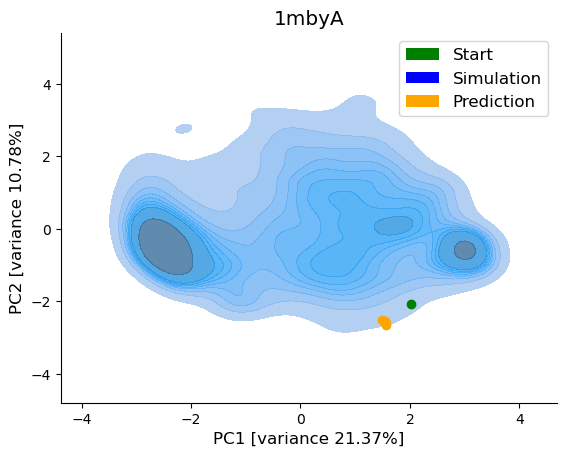

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
1mnmB,5,65861,75139,0.808,0.971,0.523,4,13,QQKERRKIEIKFI,----RRKIEIKFI


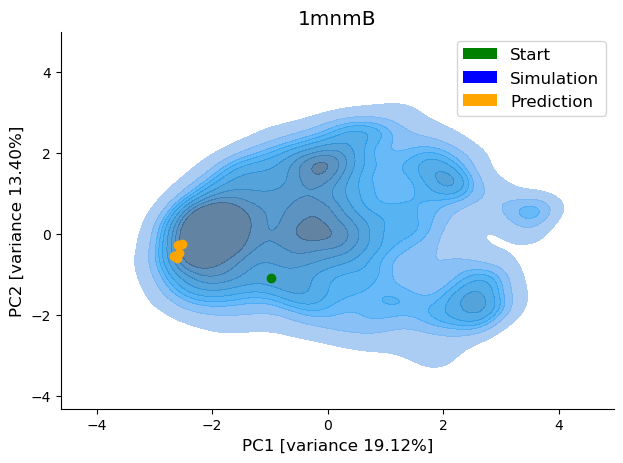

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
2jmrA,5,53592,75139,0.609,0.692,0.257,0,25,MADSTITIRGYVRDNGCSVAAESTN,MADSTITIRGYVRDNGCSVAAESTN


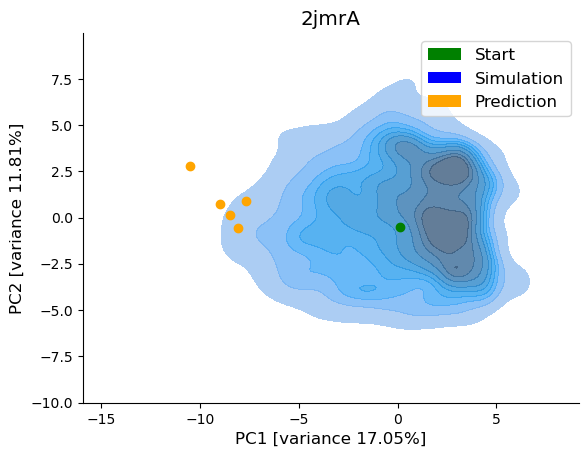

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
2k0qA,5,72148,75168,0.746,0.903,0.524,0,23,GTKIIMKGNEIFRLDEALRKGHS,GTKIIMKGNEIFRLDEALRKGHS


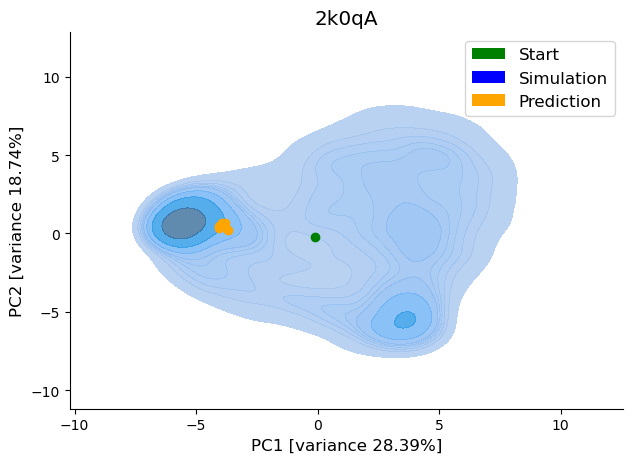

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
2lelA,5,66941,75140,0.683,0.834,0.467,0,23,GTKIIMKGNEIFRLDEALRKGHS,GTKIIMKGNEIFRLDEALRKGHS


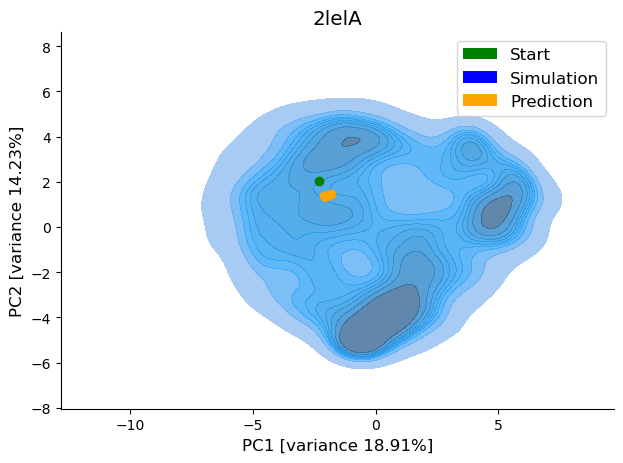

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
2naoF,5,72166,75139,0.441,0.524,0.313,0,28,QKLVFFAEDVGSNKGAIIGLMVGGVVIA,QKLVFFAEDVGSNKGAIIGLMVGGVVIA


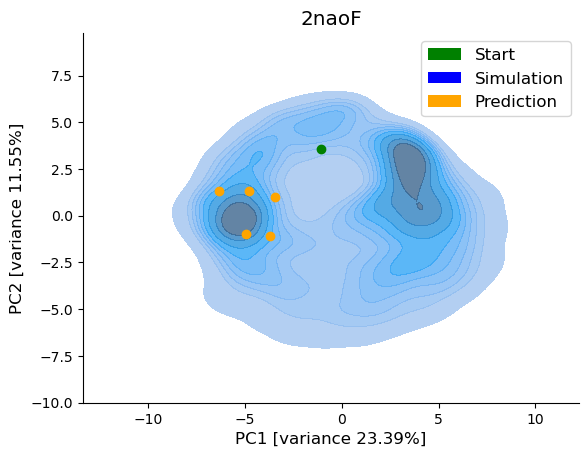

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
2nntA,5,25715,50746,0.553,0.647,0.28,0,25,GATAVSEWTEYKTADGKTFYYNNRT,GATAVSEWTEYKTADGKTFYYNNRT


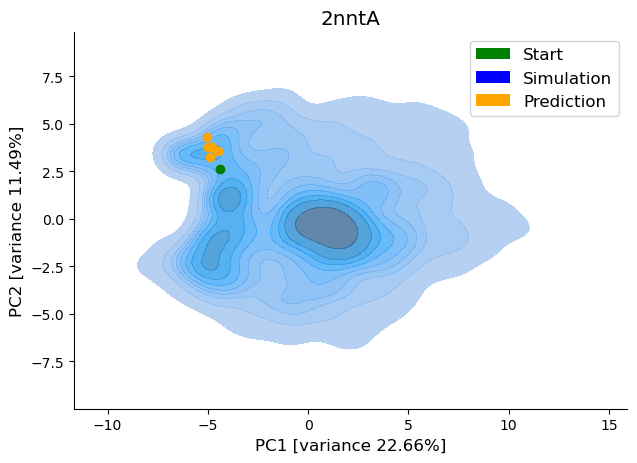

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
3o44A,5,50215,75139,0.837,0.967,0.512,1,18,TGGVEVSGDGPKAKLEAR,TGGVEVSGDGPKAKLEA-


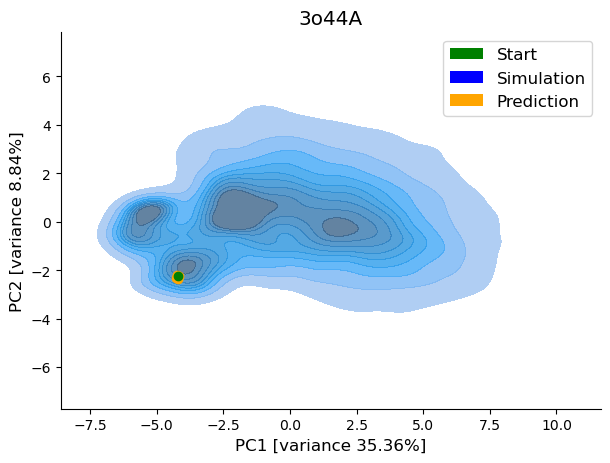

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
4a5wB,5,50101,75139,0.671,0.811,0.332,0,16,TAEDDLKTDFYKDLTS,TAEDDLKTDFYKDLTS


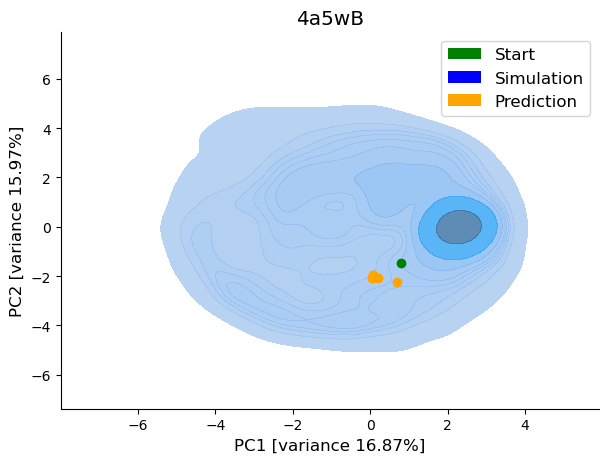

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
4g0dZ,5,73312,75167,0.784,0.925,0.536,3,23,EDDLSEEDLQFAERYLRSYYHPT,---LSEEDLQFAERYLRSYYHPT


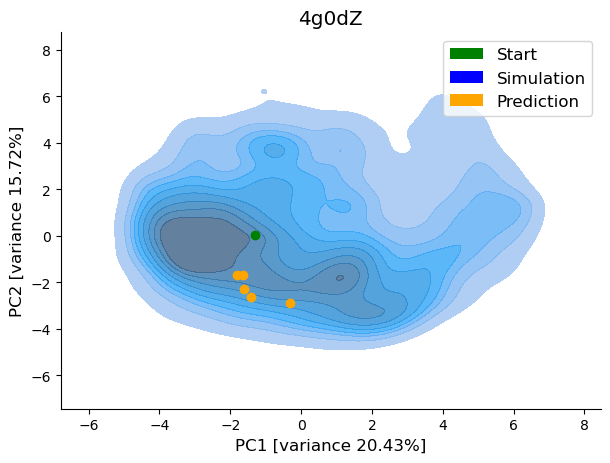

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
4rmbA,5,64484,75139,0.691,0.814,0.35,1,15,ISGDSDANAEIKLLS,ISGDSDANAEIKLL-


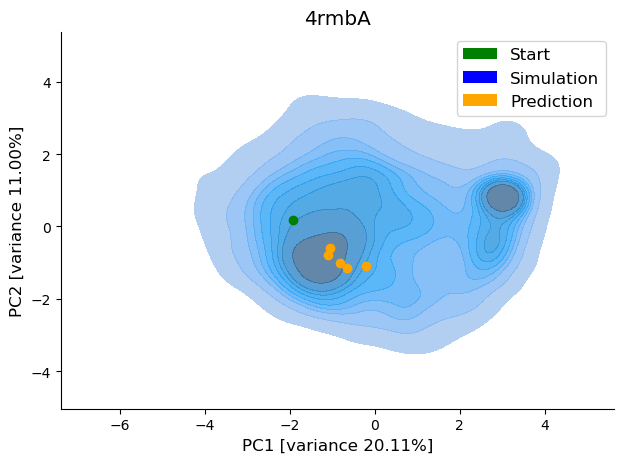

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
5k5gA,5,64802,75140,0.888,0.995,0.722,0,21,QRLANFLVHSSNNFGAILSST,QRLANFLVHSSNNFGAILSST


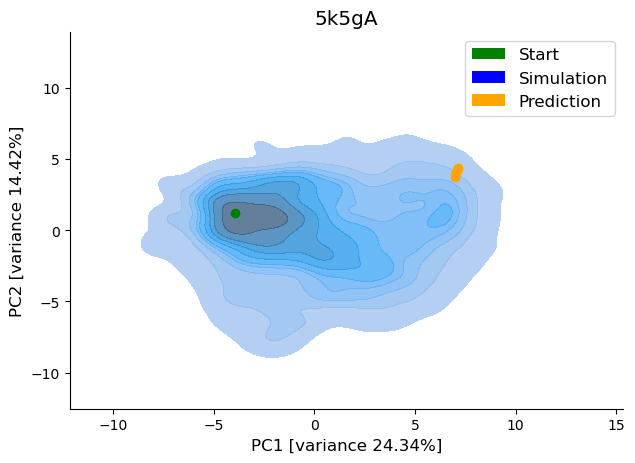

,it,index,max_index,lddt,lddt_bb,tm,bad_alignment,len_alignment,alignment_model,alignment_reference
protein,,,,,,,,,,
5keqF,5,50813,100184,0.548,0.682,0.359,2,34,PGGTLEDTYRFVTSQAIACQKHTPPAPKEDPLKK,--GTLEDTYRFVTSQAIACQKHTPPAPKEDPLKK


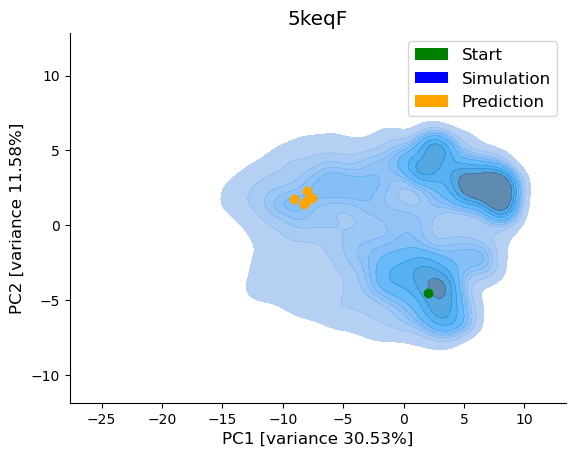

In [5]:
for hard_struc in hard_strucs:
    display(grouped[grouped.index.isin([hard_struc])][["it","index","max_index","lddt","lddt_bb","tm","bad_alignment", "len_alignment","alignment_model","alignment_reference"]])
    display(Image(filename=Path("protein_output_25032025")/hard_struc/"pca.png" ))